# Parameter tuning

Load sample areas with features from file.

In [9]:
import numpy as np
import nfhelpers as nf
import sklearn as sk

sampleAreas = np.load("numpy_objects/training_data_set_with_features.npy")

Split data into feature values - labels

In [10]:
# Extract an array with all features
X = np.array(list(map(lambda s: [s.features[key] for key in [*s.features]], sampleAreas)))

# Extract all sample areas and convert to binary (25 = True, 27 = False)
y = np.array(list(map(lambda s: 1 if s.classification == 25 else 0, sampleAreas)))

Generall settings

In [11]:
n_folds = 5
n_repeats = 20
n_threads = 16

--------
Define function for printing results and saving images and objects.

In [12]:
def print_results():
    from matplotlib import transforms
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import datetime

    date = datetime.datetime.now()

    y_values = {
        "accuracies": [],
        "recalls": [],
        "kappas": [],
        "AUROCs": [],
        "average_percisions": [],
        "f_measures": []
    }

    current_parameters = {
        "n_folds": n_folds,
        "n_repeats": n_repeats,
        "step_size": step_size,
        "param_start": param_start,
        "param_stop": param_stop
    }

    x_values = [param_value for param_value in all_metrics]

    for param_value in all_metrics:
        for metric_name in all_metrics[param_value]:
            y_values[metric_name].append(
                {
                    "mean": np.mean(all_metrics[param_value][metric_name]),
                    "min": np.min(all_metrics[param_value][metric_name]),
                    "max": np.max(all_metrics[param_value][metric_name])
                }
            )

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(y_values)))

    fig, axes = plt.subplots(3, 1)
    fig.set_size_inches(20, 17)

    top_ax, middle_ax, bottom_ax = axes

    # Top axis
    top_ax.set_xlim((0, 10))
    top_ax.set_ylim((0, 10))
    top_ax.get_xaxis().set_visible(False)
    top_ax.get_yaxis().set_visible(False) 
    top_ax.axis('off')

    header = f"({date.strftime('%Y-%m-%d %H:%M')}) ({now_testing}) Scores from best parameter value:"
    top_ax.text(5, 9, header, fontsize=24, ha='center', wrap=True)

    best_score = 0
    best_param_value = 0
    best_score_metrics = ["kappas", "AUROCs"] #["kappas", "AUROCs", "average_percisions"]

    for param_value in all_metrics:
        score = 0
        for score_metric in best_score_metrics:
            score += np.mean(all_metrics[param_value][score_metric])

        if score > best_score:
            best_score = score
            best_param_value = param_value

    current_parameters["best_param_value"] = best_param_value
    scores_from_best_param_value = all_metrics[best_param_value]

    # Left text
    for index, metric in enumerate(scores_from_best_param_value):
        y_align_index = 7 - index

        metric_mean_value = np.mean(scores_from_best_param_value[metric])
        top_ax.text(2.5, y_align_index, f"{metric}:", ha='left', fontsize=16, wrap=True)
        top_ax.text(4, y_align_index, str(metric_mean_value)[:6], fontsize=16, ha='left', wrap=True)

    # Right text
    for index, parameter in enumerate(current_parameters):
        y_align_index = 7 - index

        top_ax.text(5.5, y_align_index, f"{parameter}:", ha='left', fontsize=16, wrap=True)
        top_ax.text(7, y_align_index, str(current_parameters[parameter])[:6], fontsize=16, ha='left', wrap=True)



    # Middle axis
    for index, metric_name in enumerate(y_values):
        mean_values = list(map(lambda y_val: y_val["mean"], y_values[metric_name]))
        min_values = list(map(lambda y_val: y_val["min"], y_values[metric_name]))
        max_values = list(map(lambda y_val: y_val["max"], y_values[metric_name]))
        middle_ax.plot(x_values, mean_values, label=metric_name, color=colors[index])
        middle_ax.fill_between(x_values, min_values, max_values, color=colors[index], alpha=0.1)

    middle_ax.axvline(best_param_value, color="b", linestyle=":")
    middle_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Bottom axis
    bottom_handles = []
    bottom_lables = []

    for index, metric_name in enumerate(y_values):
        if metric_name not in best_score_metrics:
            continue

        mean_values = list(map(lambda y_val: y_val["mean"], y_values[metric_name]))
        min_values = list(map(lambda y_val: y_val["min"], y_values[metric_name]))
        max_values = list(map(lambda y_val: y_val["max"], y_values[metric_name]))

        temp_ax = bottom_ax.twinx()
        temp_ax.plot(x_values, mean_values, label=metric_name, color=colors[index])
        temp_ax.get_yaxis().set_visible(False)

        handle, lable = temp_ax.get_legend_handles_labels()
        bottom_handles.append(handle[0])
        bottom_lables.append(lable[0])

        temp_ax2 = bottom_ax.twinx()
        temp_ax2.fill_between(x_values, min_values, max_values, alpha=0.1, color=colors[index])
        temp_ax2.get_yaxis().set_visible(False)

    bottom_ax.axvline(best_param_value, color="b", linestyle=":")

    bottom_ax.legend(handles=bottom_handles, labels=bottom_lables, loc='center left', bbox_to_anchor=(1, 0.5))

    np.save(f"parameter_tuning/{now_testing}_nf-{n_folds}_nr-{n_repeats}_start-{param_start}_stop-{param_stop}_ss-{step_size}_date-{date.strftime('%Y-%m-%d %H.%M')}", all_metrics)

    plt.savefig(f"parameter_tuning/{now_testing}_nf-{n_folds}_nr-{n_repeats}_start-{param_start}_stop-{param_stop}_ss-{step_size}_date-{date.strftime('%Y-%m-%d %H.%M')}.pdf",
                bbox_inches='tight')

    plt.show()

---------------------------------------

# Metric: Estimators


In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, cohen_kappa_score, roc_auc_score, average_precision_score, f1_score
import tqdm
import multiprocessing.dummy as mp

now_testing = "estimators"

importances = []
confusion_matrices = []

metrics = {}

all_metrics = {}

step_size = 2
param_start = 10
param_stop = 300
current_param_value = 0

pbar = tqdm.tqdm_notebook(total=n_folds*n_repeats*len(range(param_start, param_stop+1, step_size)))

rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats)


def job(current_param_value):
    
    metrics = {   
        "accuracies": [],
        "recalls": [],
        "kappas": [],
        "AUROCs": [],
        "average_percisions": [], # Like AUPRC but better(?)
        "f_measures": []
    }
    
    for indices in rskf.split(X, y):

        train_index, test_index = indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        # All different input variables for the random forest algorithm.
        # Defaults afterthe parameter.
        input_n_estimators=current_param_value
        input_criterion="gini"
        input_max_depth=None 
        input_min_samples_split=2 
        input_min_samples_leaf=1
        input_min_weight_fraction_leaf=0.0
        input_max_features="auto"
        input_max_leaf_nodes=None
        input_min_impurity_decrease=0.0
        input_min_impurity_split=None
        input_bootstrap=True
        input_oob_score=False
        input_n_jobs=None
        input_random_state=None
        input_verbose=0
        input_warm_start=False
        input_class_weight=None

        # The classifier
        clf = RandomForestClassifier(
            input_n_estimators,
            input_criterion,
            input_max_depth,
            input_min_samples_split,
            input_min_samples_leaf,
            input_min_weight_fraction_leaf,
            input_max_features,
            input_max_leaf_nodes,
            input_min_impurity_decrease,
            input_min_impurity_split,
            input_bootstrap,
            input_oob_score,
            input_n_jobs,
            input_random_state,
            input_verbose,
            input_warm_start,
            input_class_weight)

        clf.fit(X_train, y_train) # (features, labels)
        y_pred = clf.predict(X_test)

        importances.append(np.array(clf.feature_importances_))
        confusion_matrices.append(confusion_matrix(y_test,y_pred))

        metrics["accuracies"].append(accuracy_score(y_test,y_pred))
        metrics["recalls"].append(recall_score(y_test,y_pred))
        metrics["kappas"].append(cohen_kappa_score(y_test,y_pred))
        metrics["AUROCs"].append(roc_auc_score(y_test,y_pred))
        metrics["average_percisions"].append(average_precision_score(y_test,y_pred))
        metrics["f_measures"].append(f1_score(y_test, y_pred))
        pbar.update();
        
    all_metrics[current_param_value] = metrics
    
    
p = mp.Pool(n_threads)
    
for _ in p.imap_unordered(job, range(param_start, param_stop+1, step_size)):       
    pass
    
p.close()
p.join()

all_metrics = {key: all_metrics[key] for key in sorted(all_metrics)}

print("Done!")

Done!


Print results from above calculations.

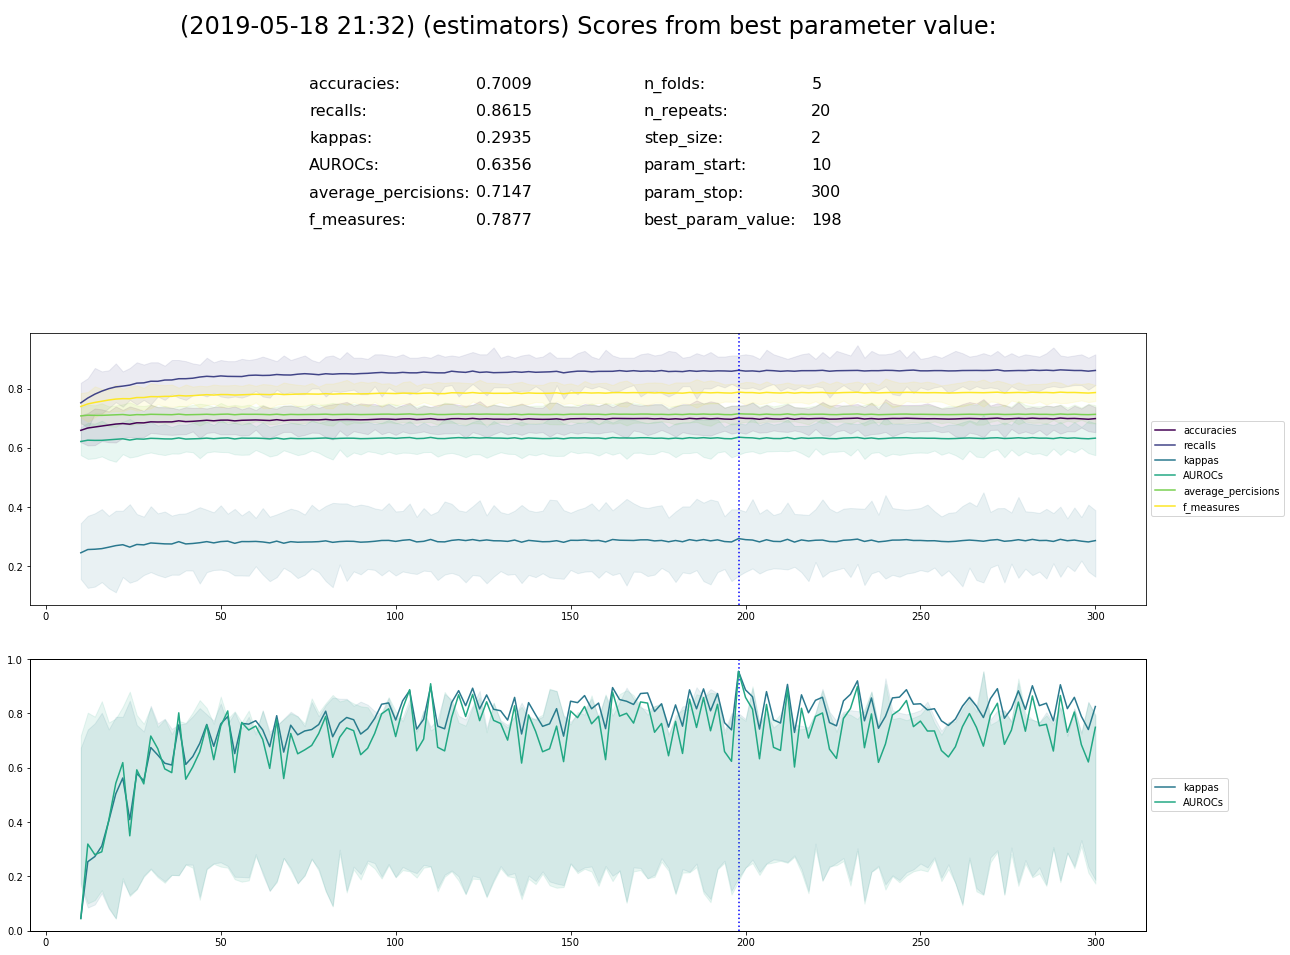

In [14]:
print_results()

---------------------------------------

# Metric: Min sample split


In [15]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, cohen_kappa_score, roc_auc_score, average_precision_score, f1_score
import tqdm
import multiprocessing.dummy as mp

now_testing = "min_samples_split"

importances = []
confusion_matrices = []

metrics = {}

all_metrics = {}

step_size = 1
param_start = 2
param_stop = 50
current_param_value = 0

pbar = tqdm.tqdm_notebook(total=n_folds*n_repeats*len(range(param_start, param_stop+1, step_size)))

rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats)


def job(current_param_value):
    
    metrics = {   
        "accuracies": [],
        "recalls": [],
        "kappas": [],
        "AUROCs": [],
        "average_percisions": [], # Like AUPRC but better(?)
        "f_measures": []
    }
    
    for indices in rskf.split(X, y):

        train_index, test_index = indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        # All different input variables for the random forest algorithm.
        # Defaults afterthe parameter.
        input_n_estimators=198
        input_criterion="gini"
        input_max_depth=None 
        input_min_samples_split=current_param_value 
        input_min_samples_leaf=1
        input_min_weight_fraction_leaf=0.0
        input_max_features="auto"
        input_max_leaf_nodes=None
        input_min_impurity_decrease=0.0
        input_min_impurity_split=None
        input_bootstrap=True
        input_oob_score=False
        input_n_jobs=None
        input_random_state=None
        input_verbose=0
        input_warm_start=False
        input_class_weight=None

        # The classifier
        clf = RandomForestClassifier(
            input_n_estimators,
            input_criterion,
            input_max_depth,
            input_min_samples_split,
            input_min_samples_leaf,
            input_min_weight_fraction_leaf,
            input_max_features,
            input_max_leaf_nodes,
            input_min_impurity_decrease,
            input_min_impurity_split,
            input_bootstrap,
            input_oob_score,
            input_n_jobs,
            input_random_state,
            input_verbose,
            input_warm_start,
            input_class_weight)

        clf.fit(X_train, y_train) # (features, labels)
        y_pred = clf.predict(X_test)

        importances.append(np.array(clf.feature_importances_))
        confusion_matrices.append(confusion_matrix(y_test,y_pred))

        metrics["accuracies"].append(accuracy_score(y_test,y_pred))
        metrics["recalls"].append(recall_score(y_test,y_pred))
        metrics["kappas"].append(cohen_kappa_score(y_test,y_pred))
        metrics["AUROCs"].append(roc_auc_score(y_test,y_pred))
        metrics["average_percisions"].append(average_precision_score(y_test,y_pred))
        metrics["f_measures"].append(f1_score(y_test, y_pred))
        pbar.update();
        
    all_metrics[current_param_value] = metrics
    

    
p = mp.Pool(n_threads)
    
for _ in p.imap_unordered(job, range(param_start, param_stop+1, step_size)):       
    pass
    
p.close()
p.join()

all_metrics = {key: all_metrics[key] for key in sorted(all_metrics)}

print("Done!")

Done!


Print results from above calculations.

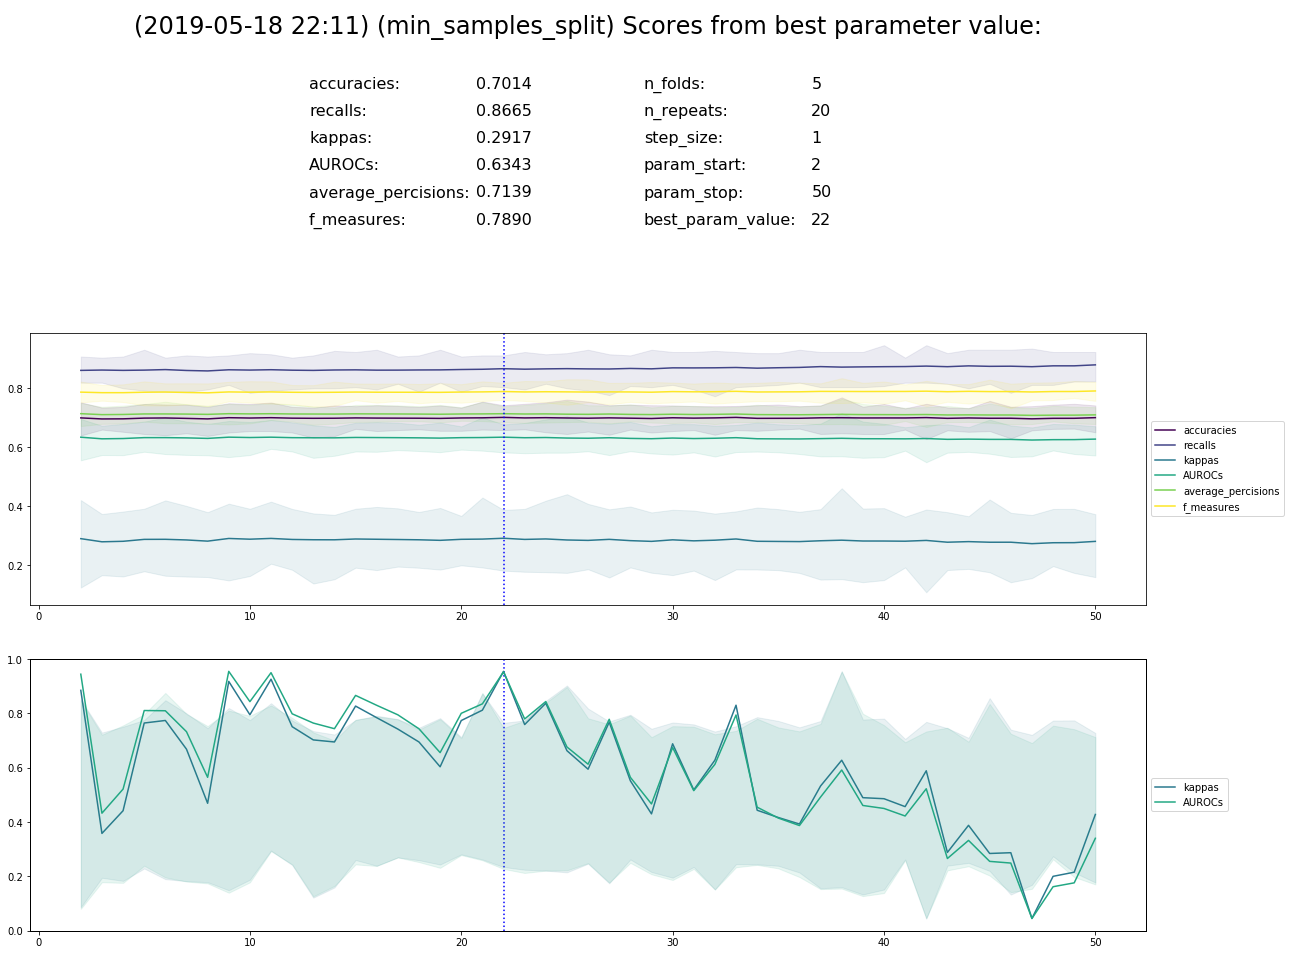

In [16]:
print_results()

---------------------------------------

# Metric: Max features


In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, cohen_kappa_score, roc_auc_score, average_precision_score, f1_score
import tqdm
import multiprocessing.dummy as mp

now_testing = "max_features"

importances = []
confusion_matrices = []

metrics = {}

all_metrics = {}

step_size = 1
param_start = 2
param_stop = len(sampleAreas[0].features)
current_param_value = 0

pbar = tqdm.tqdm_notebook(total=n_folds*n_repeats*len(range(param_start, param_stop+1, step_size)))

rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats)


def job(current_param_value):
    
    metrics = {   
        "accuracies": [],
        "recalls": [],
        "kappas": [],
        "AUROCs": [],
        "average_percisions": [], # Like AUPRC but better(?)
        "f_measures": []
    }
    
    for indices in rskf.split(X, y):

        train_index, test_index = indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        # All different input variables for the random forest algorithm.
        # Defaults afterthe parameter.
        input_n_estimators=100
        input_criterion="gini"
        input_max_depth=None 
        input_min_samples_split=2 
        input_min_samples_leaf=1
        input_min_weight_fraction_leaf=0.0
        input_max_features=current_param_value
        input_max_leaf_nodes=None
        input_min_impurity_decrease=0.0
        input_min_impurity_split=None
        input_bootstrap=True
        input_oob_score=False
        input_n_jobs=None
        input_random_state=None
        input_verbose=0
        input_warm_start=False
        input_class_weight=None

        # The classifier
        clf = RandomForestClassifier(
            input_n_estimators,
            input_criterion,
            input_max_depth,
            input_min_samples_split,
            input_min_samples_leaf,
            input_min_weight_fraction_leaf,
            input_max_features,
            input_max_leaf_nodes,
            input_min_impurity_decrease,
            input_min_impurity_split,
            input_bootstrap,
            input_oob_score,
            input_n_jobs,
            input_random_state,
            input_verbose,
            input_warm_start,
            input_class_weight)

        clf.fit(X_train, y_train) # (features, labels)
        y_pred = clf.predict(X_test)

        importances.append(np.array(clf.feature_importances_))
        confusion_matrices.append(confusion_matrix(y_test,y_pred))

        metrics["accuracies"].append(accuracy_score(y_test,y_pred))
        metrics["recalls"].append(recall_score(y_test,y_pred))
        metrics["kappas"].append(cohen_kappa_score(y_test,y_pred))
        metrics["AUROCs"].append(roc_auc_score(y_test,y_pred))
        metrics["average_percisions"].append(average_precision_score(y_test,y_pred))
        metrics["f_measures"].append(f1_score(y_test, y_pred))
        pbar.update();
        
    all_metrics[current_param_value] = metrics
    
    
p = mp.Pool(n_threads)
    
for _ in p.imap_unordered(job, range(param_start, param_stop+1, step_size)):       
    pass
    
p.close()
p.join()

all_metrics = {key: all_metrics[key] for key in sorted(all_metrics)}

print("Done!")

Done!


Print results from above calculations.

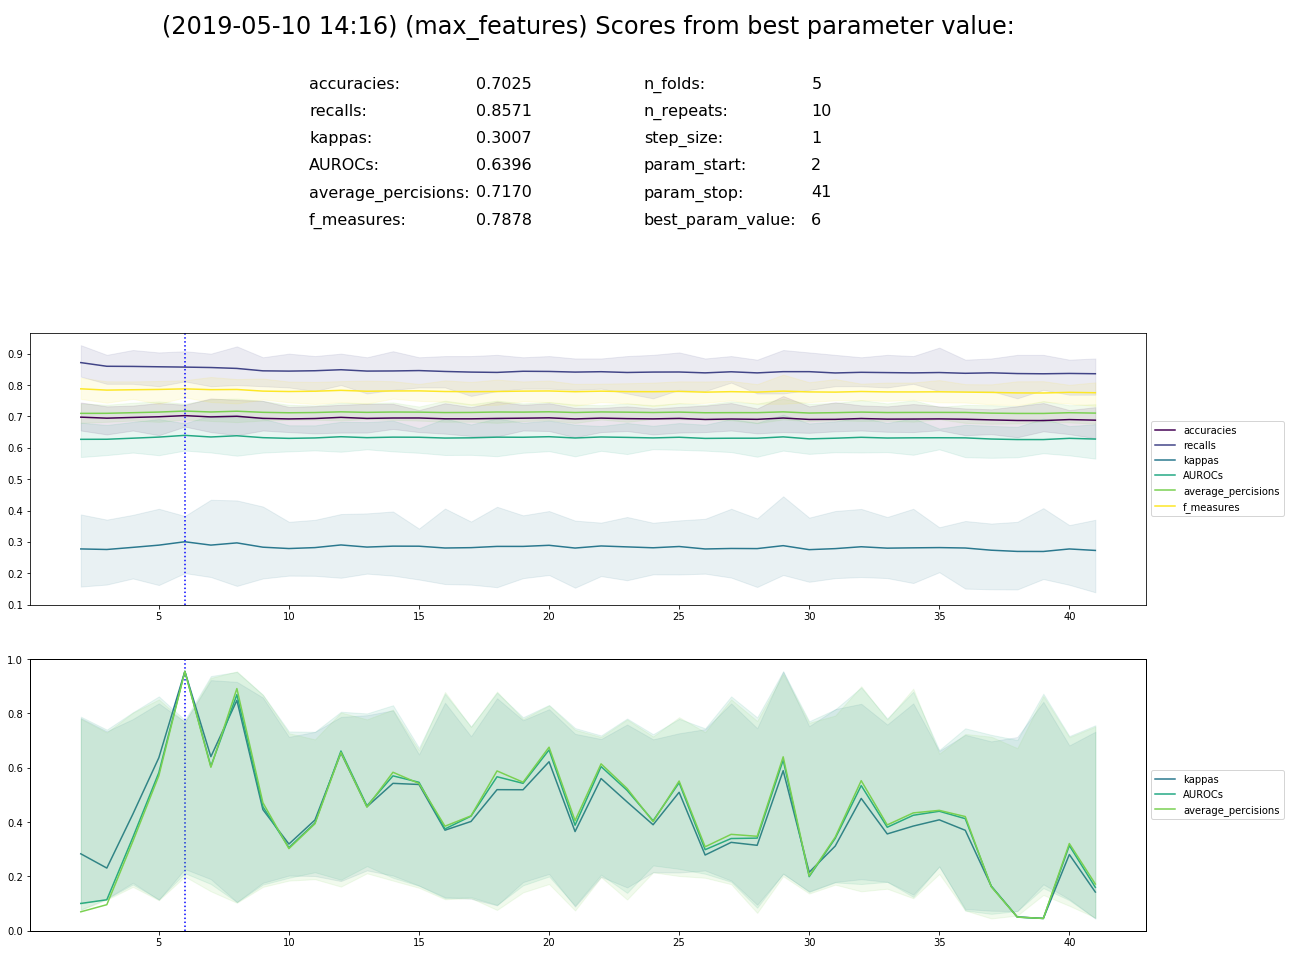

In [21]:
print_results()

---------------------------------------

# Metric: Min weight fraction leaf


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, cohen_kappa_score, roc_auc_score, average_precision_score, f1_score
import tqdm
import multiprocessing.dummy as mp

now_testing = "min_weight_fraction_leaf"

importances = []
confusion_matrices = []

metrics = {}

all_metrics = {}

step_size = 0.02
param_start = 0.0
param_stop = 0.5
current_param_value = 0

pbar = tqdm.tqdm_notebook(total=n_folds*n_repeats*len(range(int(param_start*100), int(param_stop+1*100),int(step_size*100))))

rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats)


def job(current_param_value):
    
    current_param_value = current_param_value / 100
    
    metrics = {   
        "accuracies": [],
        "recalls": [],
        "kappas": [],
        "AUROCs": [],
        "average_percisions": [], # Like AUPRC but better(?)
        "f_measures": []
    }
    
    for indices in rskf.split(X, y):

        train_index, test_index = indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        # All different input variables for the random forest algorithm.
        # Defaults afterthe parameter.
        input_n_estimators=100
        input_criterion="gini"
        input_max_depth=None 
        input_min_samples_split=2 
        input_min_samples_leaf=1
        input_min_weight_fraction_leaf=current_param_value
        input_max_features="auto"
        input_max_leaf_nodes=None
        input_min_impurity_decrease=0.0
        input_min_impurity_split=None
        input_bootstrap=True
        input_oob_score=False
        input_n_jobs=None
        input_random_state=None
        input_verbose=0
        input_warm_start=False
        input_class_weight=None

        # The classifier
        clf = RandomForestClassifier(
            input_n_estimators,
            input_criterion,
            input_max_depth,
            input_min_samples_split,
            input_min_samples_leaf,
            input_min_weight_fraction_leaf,
            input_max_features,
            input_max_leaf_nodes,
            input_min_impurity_decrease,
            input_min_impurity_split,
            input_bootstrap,
            input_oob_score,
            input_n_jobs,
            input_random_state,
            input_verbose,
            input_warm_start,
            input_class_weight)

        clf.fit(X_train, y_train) # (features, labels)
        y_pred = clf.predict(X_test)

        importances.append(np.array(clf.feature_importances_))
        confusion_matrices.append(confusion_matrix(y_test,y_pred))

        metrics["accuracies"].append(accuracy_score(y_test,y_pred))
        metrics["recalls"].append(recall_score(y_test,y_pred))
        metrics["kappas"].append(cohen_kappa_score(y_test,y_pred))
        metrics["AUROCs"].append(roc_auc_score(y_test,y_pred))
        metrics["average_percisions"].append(average_precision_score(y_test,y_pred))
        metrics["f_measures"].append(f1_score(y_test, y_pred))
        pbar.update();
        
    all_metrics[current_param_value] = metrics
    
    
p = mp.Pool(n_threads)
    
for _ in p.imap_unordered(job, range(int(param_start*100), int(param_stop+1*100),int(step_size*100))):       
    pass
    
p.close()
p.join()

all_metrics = {key: all_metrics[key] for key in sorted(all_metrics)}

print("Done!")

Print results from above calculations.

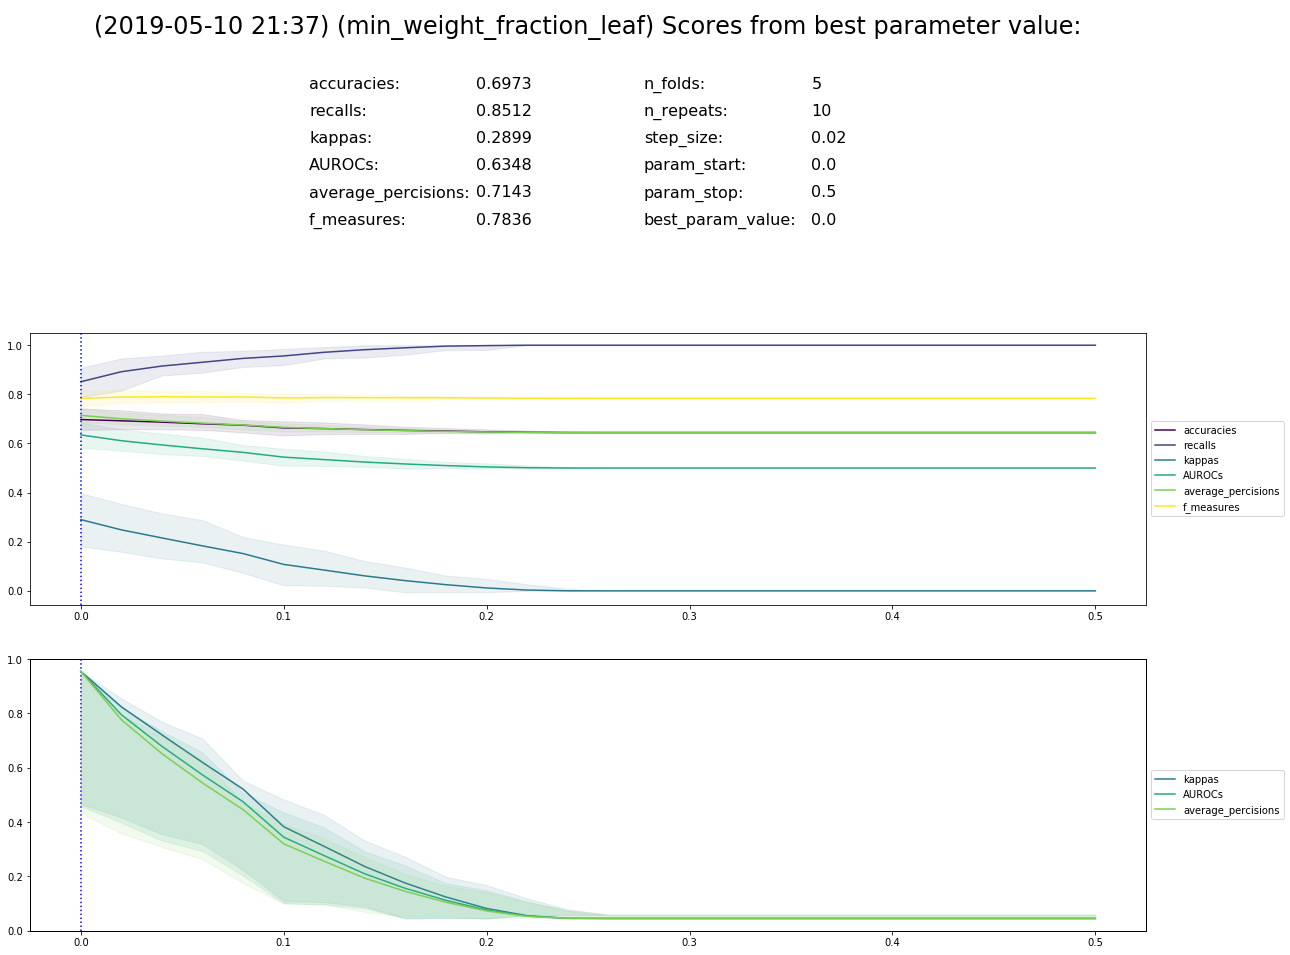

In [8]:
all_metrics = {key: all_metrics[key] for key in sorted(all_metrics)}
print_results()